In [63]:
import sys
!{sys.executable} -m pip install pip --upgrade
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install webdriver_manager

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


In [2]:
import numpy as np
import pandas as pd
from functions import *
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

# **Computational Tools for Data Science Final Project**


## Getting and Cleaning the Data

Our main goal is to classify the books with text simmilarity ( using summaries) and predict their genre correctly. Moreover, we want to make a simple recomendation UI using github pages which the user can choose between time, rating , genre and get some recomendation based on our classification model.

In this project we are going to use a cleaned up version of this [data set from Kaggle](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews?select=books_data.csv&fbclid=IwAR3H0BlyYyiNodMoF0GbzknzNMyriDa_9eL00g1if_Y29QBPcobfeHQpZCE).

This dataset contains two csv files, one containg the book ratings and another contaning information about the books. To cleanup the dataset we want to combine the two csvs for ease of use and remove any unwanted rows and string characters. Post cleanup there are 41406 books with columns:
* Title
* authors
* publishedDate
* clean_summary
* clean_categories
* averageRating

In [ ]:
# read csv files downloaded from Kaggle (not runnable off the bat, csv too big for github)
original_books = pd.read_csv(b='books_data.csv')
original_ratings = pd.read_csv(b='Books_rating.csv')

#writing to clean data with ratings combined
for index, row in original_books.iterrows():
    dum_pd = original_ratings[original_ratings['Title'] == row['Title']]
    aveRating = round(sum(dum_pd['review/score'])/len(dum_pd.index), 2)
    original_books.at[index, 'averageRating'] = aveRating

# write to csv file
original_books.to_csv('books_and_ratings.csv')

In [43]:
# Load in books + ratings csv created before
clean_books1 = pd.read_csv('books_and_ratings.csv')

# Selecting specific columns that are relevant to the project
clean_books1 = clean_books1[["Title","description","authors","publishedDate","categories","averageRating","previewLink"]]

# Clean up the description and categories columns (removing punctuation and )
clean_books1['clean_summary'] = clean_books1['description'].apply(lambda x: clean_books(x))
#clean_books1['clean_authors'] = clean_books1['authors'].apply(lambda x: clean_books(x))
clean_books1['clean_categories'] = clean_books1['categories'].apply(lambda x: clean_books(x))

# Drop all rows with null in them
clean_books1 = clean_books1.dropna()
print(clean_books1.columns)

# Write to new csv file
clean_books1.to_csv("final.csv")


Index(['Title', 'description', 'authors', 'publishedDate', 'categories',
       'averageRating', 'previewLink', 'clean_summary', 'clean_categories'],
      dtype='object')


## KMeans Analysis

Now let's analyze the data a bit better and see if it can be grouped together by description even after the clean up and shrinking of the dataset. We want to remove unwanted stopwords (i.e. the, a, to, etc) that appear frequently in text regardless of the context. This will give us a more accurate look at 

In [44]:
book_reviews_pd = pd.read_csv("final.csv")
book_reviews_pd['clean_summary'] = book_reviews_pd['clean_summary'].apply(lambda x: clean_books(x))

In [35]:
stop_words = set(stopwords.words('english')) 
for index, row in book_reviews_pd["clean_summary"].items():
    if  isinstance(row, str):
        sum_arr = row.split(" ")
        for word in sum_arr:
            if word in stop_words:
                sum_arr.remove(word)
        sum_str = ' '.join(sum_arr)
        book_reviews_pd['clean_summary'].loc[index] = sum_str

/var/folders/zn/5wg9cgvx6jg1qrfz458d4m900000gn/T/ipykernel_41815/2643365223.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_reviews_pd['clean_summary'].loc[index] = sum_str


In [29]:
data = book_reviews_pd['clean_summary']
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',
                             max_features = 20000)

tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [30]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'lloyd')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

In [31]:
kmeans2 = KMeans(n_clusters= 10)
label = kmeans2.fit_predict(Y_sklearn)
filtered_label0 = Y_sklearn[label == 0]

In [13]:
print(len(label))

41406


In [33]:
genre_dict = {}
for index in range(len(label)):
    if label[index] in genre_dict.keys():
        genre_dict[label[index]].add(book_reviews_pd.loc[index]['clean_categories'])
    else:
        genre_dict[label[index]] = set([(book_reviews_pd.loc[index]['clean_categories'])])


In [34]:
print(genre_dict[3])

{'house design', 'business economics', 'religion', 'history', 'juvenile nonfiction', 'cooking', 'biography autobiography', 'art', 'science', 'transportation', 'animals', 'electronics', 'north america', 'health fitness', 'performing arts', 'europe', 'education', 'families', 'reference', 'philosophy', 'gardening', 'literature', 'fiction', 'asia', 'psychology', 'medical', 'games activities', 'language', 'travel', 'music'}


From this grouping based on the summaries alone one can see that there might be a little bit of relationship between the books based on the summaries since there are some similar genres. But there is also a wide variety of genres that get grouped together. This is possibly due to the fact that we do not have enough data to narrow down to only one genre. But we can also use this to our advantage where we can now find similar books to the one being looked up but also broaden the users horizons by recommending books that fit partially within the scope just in a different genre.

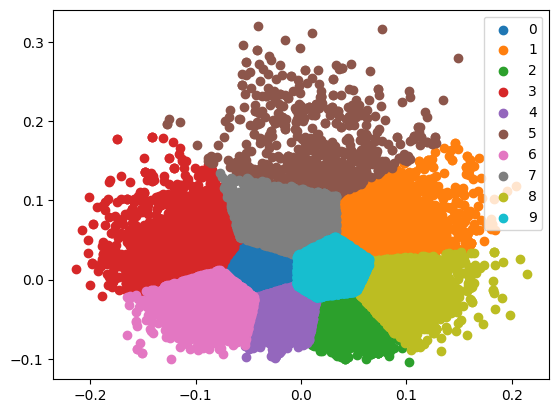

In [32]:
u_labels = np.unique(label)
 
for i in u_labels:
    plt.scatter(Y_sklearn[label == i , 0] , Y_sklearn[label == i , 1] , label = i)
plt.legend()
plt.show()

## Recommendation System and Model Building

In [24]:
test = book_reviews_pd[[ 'clean_summary' , 'Title'] ]


Now we want to create a hash to base our recommendation system on from the summary and book title.

In [25]:
test_words =  tuple(test['clean_summary'])
test_hash = tuple(test['Title'])

Then we use the hash we created to create a TaggedDocument for use in the model build. For the build of the model we made use of some knowledge learned in Deep Learning to get a better result in our recommendation system since as was seen in the KMeans analysis the summaries are not enough on their own.

In [32]:
docs = [TaggedDocument(
             words=[word for word in test_words.lower().split()],
             tags=[i]
         ) for i, test_words in enumerate(test_hash)]

In [36]:
max_epochs = 4
vec_size = 200
alpha = 0.0025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.0025,
                min_count=0.00001,
                dm =1)
  
model.build_vocab(docs)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(docs,
                total_examples=model.corpus_count,
                epochs= max_epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2vtestL.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
Model Saved


In [39]:
model= Doc2Vec.load("d2v.model")


# to find most similar doc using tags
similar_doc = model.docvecs.most_similar(2)
print(similar_doc)
#print(model.docvecs['1'])

[(13123, 0.9982852339744568), (22398, 0.9980025887489319), (1324, 0.9979535937309265), (188, 0.9979435801506042), (28364, 0.9979380369186401), (5379, 0.997916042804718), (24235, 0.9979107975959778), (466, 0.9979106783866882), (16369, 0.9979103803634644), (21210, 0.9978847503662109)]


/var/folders/zn/5wg9cgvx6jg1qrfz458d4m900000gn/T/ipykernel_18103/3416598151.py:5: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_doc = model.docvecs.most_similar(2)


## Final result
Here is a small sample of a function to search for the correct recommendations based on a book title from the user. It returns the top 5 recommendations.

In [38]:
def search_books(title_str):
    book_reviews_pd = pd.read_csv('final.csv')
    test = book_reviews_pd[[ 'clean_summary' , 'Title'] ]
    test_hash = tuple(test['Title'])
    # Get the index to search by in the model
    index = book_reviews_pd.index[book_reviews_pd['Title'] == title_str].to_list()[0]

    model= Doc2Vec.load("d2v.model")
    
    # Search for the most similar through the model
    most_similar_docs = []
    for d in model.dv.most_similar([index]):
        most_similar_docs.append(test_hash[d[0]])

    recommendations = pd.DataFrame()
    for title in most_similar_docs:
        new_row = book_reviews_pd.loc[book_reviews_pd['Title'] == title]
        recommendations = pd.concat([recommendations, new_row])

    # Return top 5 of the recommended books
    return recommendations.head(5)

print(search_books('Oryx and Crake'))

       Unnamed: 0                  Title  \
25621       25881  Caesar and Cleopatra,   
32194       32529   Functions and Graphs   
24995       25250    Laundry and Bourbon   
16267       16455          Max and Felix   
29518       29826    Snakes and Earrings   

                                                 authors publishedDate  \
25621         ['George Bernard Shaw', 'Dan H. Laurence']    2006-06-27   
32194  ['I. M. Gelfand', 'E. G. Glagoleva', 'E. E. Sh...    2013-04-09   
24995                                   ['James McLure']          1981   
16267                             ['Larry Dane Brimner']          2001   
29518                                ['Hitomi Kanehara']          2005   

                                           clean_summary clean_categories  \
25621  exclusive to penguin classics the definitive t...  performing arts   
32194  this text demonstrates the fundamentals of gra...        education   
24995  the story the setting is the front porch of ro...  p

## Output

Now that we have analyzed the data and created a recommendation model we decided to create a GUI to go with it which can be found by running 'View/recommendation_app.py' and inputting a book title you are interested in.